In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, SVD, KNNBasic
from surprise.model_selection import cross_validate

In [22]:
movies = pd.read_csv('/kaggle/input/the-movies-dataset/ratings_small.csv',
                    usecols=["userId","movieId","rating","timestamp"])

## a. Read data

In [23]:
movies.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


## C. Compute the average MAE and RMSE of PMF, UserBased, ItemBased under 5-folds cross-validation

In [12]:
algos = {
    "PMF": SVD(),
    "User based": KNNBasic(sim_options={'user_based': True}),
    "Item based": KNNBasic(sim_options={'user_based': False})
}

# ========= Perform cross validation ==========
for algo_name, algo in algos.items():
    results = cross_validate(algo, movies, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    avg_rmse = sum(results['test_rmse']) / len(results['test_rmse'])
    avg_mae = sum(results['test_mae']) / len(results['test_mae'])
    print("==============================")
    print(f"{algo_name}:")
    print(f"average RMSE =  {avg_rmse}")
    print(f"average MAE =  {avg_mae}")
    print("==============================")

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8937  0.8882  0.9012  0.9094  0.8873  0.8960  0.0084  
MAE (testset)     0.6887  0.6813  0.6936  0.6989  0.6860  0.6897  0.0061  
Fit time          1.44    1.50    1.46    1.44    1.48    1.46    0.02    
Test time         0.18    0.19    0.19    0.18    0.18    0.18    0.00    
PMF:
average RMSE =  0.8959606660920307
average MAE =  0.6897102922672917
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std    

## D. Compare the average (mean) performances of User-based,item-based, PMF with respect to RMSE and MAE.

In [14]:
algos = {
    "PMF": SVD(),
    "User based": KNNBasic(sim_options={'user_based': True}),
    "Item based": KNNBasic(sim_options={'user_based': False})
}

# ======== store avg ==========
avg_rmse = {}
avg_mae = {}

# ======== cross validation=================
for algo_name, algo in algos.items():
    results = cross_validate(algo, movies, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    avg_rmse[algo_name] = sum(results['test_rmse']) / len(results['test_rmse'])
    avg_mae[algo_name] = sum(results['test_mae']) / len(results['test_mae'])
    
# ========== Compare the average performances ===========
for algo_name in algos:
    print(f"{algo_name}:")
    print(f"Average RMSE = {avg_rmse[algo_name]}")
    print(f"Average MAE = {avg_mae[algo_name]}")
    print("==============================")

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8992  0.8947  0.8962  0.8981  0.8923  0.8961  0.0024  
MAE (testset)     0.6943  0.6870  0.6872  0.6917  0.6897  0.6900  0.0028  
Fit time          1.42    1.45    1.46    1.45    1.46    1.45    0.01    
Test time         0.18    0.18    0.19    0.35    0.18    0.22    0.07    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9664  0.9704  0.9750  0.9623  0.9638  0.9676  0.0046

## E. Examine how the cosine, MSD  Pearson similarities impact the performances of User based, Item based. Plot your results

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd sim

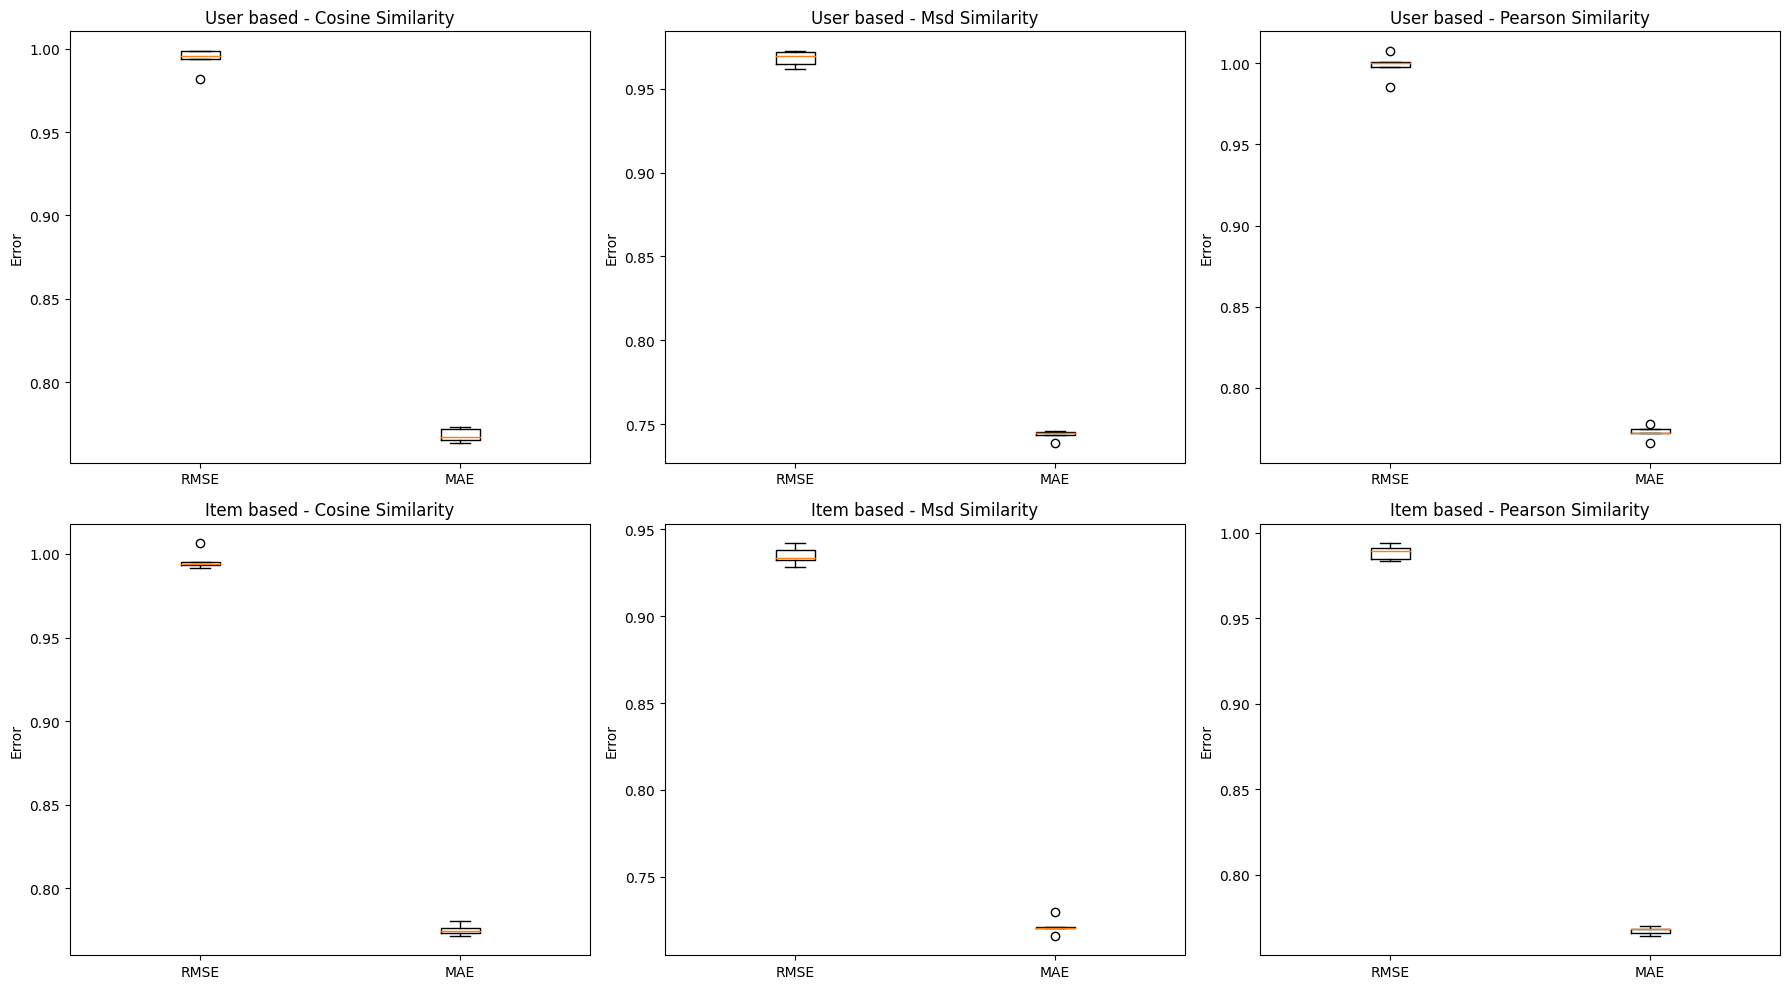

In [16]:
similarity_metrics = ['cosine', 'msd', 'pearson']

results = {'User based': {}, 'Item based': {}}

for metric in similarity_metrics:
    for algo_name in results.keys():
        algo = KNNBasic(sim_options={'name': metric, 'user_based': (algo_name == 'User based')})
        results[algo_name][metric] = cross_validate(algo, movies, measures=['RMSE', 'MAE'], cv=5, verbose=False)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
for i, algo_name in enumerate(results.keys()):
    for j, metric in enumerate(similarity_metrics):
        ax = axes[i, j]
        rmse_values = results[algo_name][metric]['test_rmse']
        mae_values = results[algo_name][metric]['test_mae']
        ax.boxplot([rmse_values, mae_values], labels=['RMSE', 'MAE'])
        ax.set_title(f"{algo_name} - {metric.capitalize()} Similarity")
        ax.set_ylabel('Error')
plt.tight_layout()
plt.show()

## F. Examine how the number of neighbors impacts the performances of User based & Item based Collaborative Filtering? Plot your results.

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th

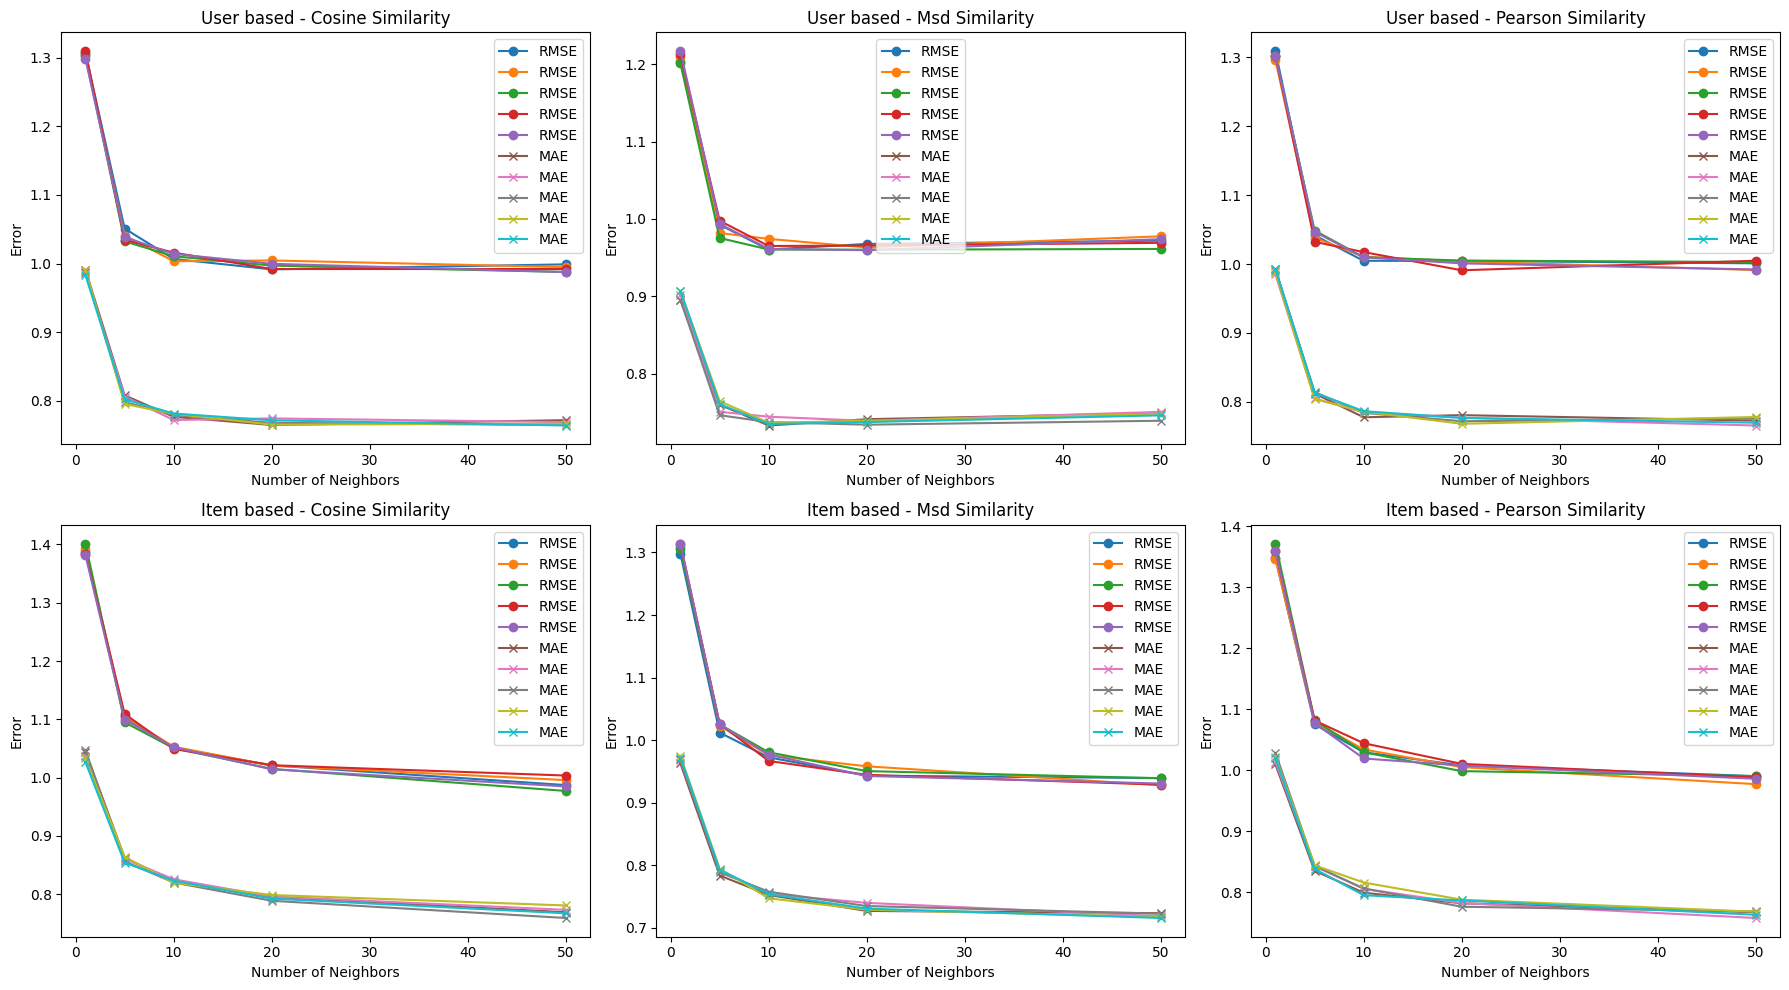

In [17]:
similarity_metrics = ['cosine', 'msd', 'pearson']
num_neighbors = [1, 5, 10, 20, 50] 

results = {'User based': {}, 'Item based': {}}

for metric in similarity_metrics:
    for algo_name in results.keys():
        for k in num_neighbors:
            algo = KNNBasic(k=k, sim_options={'name': metric, 'user_based': (algo_name == 'User based')})
            results[algo_name][metric, k] = cross_validate(algo, movies, measures=['RMSE', 'MAE'], cv=5, verbose=False)

fig, axes = plt.subplots(nrows=2, ncols=len(similarity_metrics), figsize=(18, 10))
for i, algo_name in enumerate(results.keys()):
    for j, metric in enumerate(similarity_metrics):
        ax = axes[i, j]
        rmse_values = [results[algo_name][(metric, k)]['test_rmse'] for k in num_neighbors]
        mae_values = [results[algo_name][(metric, k)]['test_mae'] for k in num_neighbors]
        ax.plot(num_neighbors, rmse_values, marker='o', label='RMSE')
        ax.plot(num_neighbors, mae_values, marker='x', label='MAE')
        ax.set_title(f"{algo_name} - {metric.capitalize()} Similarity")
        ax.set_xlabel('Number of Neighbors')
        ax.set_ylabel('Error')
        ax.legend()
plt.tight_layout()
plt.show()

## G. Identify the best number of neighbor (denoted by K) for User/Item based in terms of RMSE. Is the best K of User based  the same with the best K of Item based?

In [18]:
similarity_metrics = ['cosine', 'msd', 'pearson']
num_neighbors = [1, 5, 10, 20, 50]

results = {'User based': {}, 'Item based': {}}

for metric in similarity_metrics:
    for algo_name in results.keys():
        rmse_values = []
        for k in num_neighbors:
            algo = KNNBasic(k=k, sim_options={'name': metric, 'user_based': (algo_name == 'User based')})
            cv_results = cross_validate(algo, movies, measures=['RMSE'], cv=5, verbose=False)
            avg_rmse = cv_results['test_rmse'].mean()
            rmse_values.append(avg_rmse)
        best_k = num_neighbors[rmse_values.index(min(rmse_values))]
        results[algo_name][metric] = {'best_k': best_k, 'best_rmse': min(rmse_values)}

for algo_name in results.keys():
    print(f"{algo_name} collaborative filtering:")
    for metric in similarity_metrics:
        best_k = results[algo_name][metric]['best_k']
        best_rmse = results[algo_name][metric]['best_rmse']
        print(f"Best K for {metric.capitalize()} similarity: {best_k}, Best RMSE: {best_rmse}")


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing th